In [13]:


import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import imageio
from PIL import Image, ImageDraw, ImageFont


import os



In [14]:
class DQN(nn.Module):
     def __init__(self, n_states, n_hiden, n_action):
        super().__init__()

        self.fc1=nn.Linear(n_states,n_hiden)
        self.fc2=nn.Linear(n_hiden,n_action)

     def forward(self,x):

        x=F.relu(self.fc1(x))
        x=self.fc2(x)

        return x


In [15]:

class Memory():
       def __init__(self, memory_size) :
        
         self.memory = deque(maxlen=memory_size)

       def append(self, transition):

         self.memory.append(transition)

       def sample(self, sample_size)  :

         return random.sample(self.memory, sample_size)

       def __len__(self ) :
          return len(self.memory) 

In [16]:
class FrozenLakeDQN():

       learning_rate=0.001
       batch_size=32
       sync_rate=10
       memory_size=1000
       discount_factor=0.9

       loss_fn = nn.MSELoss()         
       optimizer = None  

       def state_to_onehot(self,state, num_states):
           onehot = torch.zeros(num_states)
           onehot[state] = 1  # subtract 1 because Python is 0-indexed
           return onehot



       def train (self, episodes, is_slippery,render=False):
           
             env=gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery,render_mode='human' if render else None)
             memory=Memory(self.memory_size)

             self.number_states=env.observation_space.n
             self.num_action=env.action_space.n


             Policy_network=DQN(n_states=self.number_states, n_hiden=self.number_states, n_action= self.num_action)
             Target_network=DQN(n_states=self.number_states, n_hiden=self.number_states, n_action= self.num_action)

             Target_network.load_state_dict(Policy_network.state_dict())

             self.optimizer=torch.optim.Adam(Policy_network.parameters(), lr=self.learning_rate)
             epsilon=1
             rewards_per_episode = []

             step_count=0 

             for i in range(episodes):

                state,_ = env.reset()
                terminated=False
                truncated=False

                while (not terminated and not truncated):

                    if random.uniform(0, 1) < epsilon:
                         action=env.action_space.sample()
                    else:
                         with torch.no_grad():
                             action=Policy_network(self.state_to_onehot(state, self.number_states)).argmax().item()

                    next_state, reward, terminated, truncated, info= env.step(action)
                    memory.append((state,action,next_state,reward,terminated))
                    state=next_state
                    step_count+=1

                rewards_per_episode.append(reward)


                if len(memory)>self.batch_size and np.sum(rewards_per_episode)>0 :

                    sample=memory.sample(self.batch_size)
                    self.optimize(sample,Policy_network,Target_network)
                    
                    epsilon = max(epsilon - 1/episodes, 0)

                    if step_count> self.sync_rate :
                       Target_network.load_state_dict(Policy_network.state_dict()) 
                       step_count=0 

             env.close()

             os.makedirs("results/plots", exist_ok=True)

             torch.save(Policy_network.state_dict(), "frozen_lake_dql.pt")
             # ---- Plot Learning Curve ----
             window = 50  # moving average window
             if len(rewards_per_episode) >= window:
                      moving_avg = np.convolve(rewards_per_episode, 
                             np.ones(window)/window, 
                             mode='valid')
             else:
                    moving_avg = rewards_per_episode

             plt.figure(figsize=(10,5))
             plt.plot(range(window-1, window-1+len(moving_avg)), moving_avg,
             label=f"Moving Average (window={window})", linewidth=3)
             plt.xlabel("Episode")
             plt.ylabel("Reward")
             plt.title("Learning Curve — FrozenLake DQN")
             plt.legend()
             plt.grid()
             plt.show()
             plt.savefig("results/plots/learning_curve.png", dpi=300)



       def test(self, episodes, is_slippery):

           
            # Create folder for results
             os.makedirs("results/videos", exist_ok=True)

            # Use RGB mode for GIF
             env = gym.make("FrozenLake-v1", map_name="4x4",
                   is_slippery=is_slippery,
                   render_mode="rgb_array")

             number_states = env.observation_space.n
             num_action = env.action_space.n

    # Load trained policy
             Policy = DQN(n_states=number_states, n_hiden=number_states, n_action=num_action)
             Policy.load_state_dict(torch.load("frozen_lake_dql.pt", weights_only=True))
             Policy.eval()

             for episode in range(episodes):

               state, _ = env.reset()
               done = False
               truncated = False

               frames = []   # store frames per episode
               max_steps = 200

               print("Episode", episode)

               for step in range(max_steps):

        
                   frame = env.render()
                   if frame is not None:
                     frames.append(np.array(frame, dtype=np.uint8))

  
                   with torch.no_grad():
                         action = Policy(self.state_to_onehot(state, number_states)).argmax().item()

                   next_state, reward, done, truncated, info = env.step(action)
                   state = next_state

                   if done or truncated:
                       frames.append(env.render())
                       print(f"Finished episode {episode} with reward {reward}")
                       break

               # Save GIF
               gif_path = f"results/videos/frozenlake_episode_{episode}.gif"
               imageio.mimsave(gif_path, frames, fps=4)
               print("Saved GIF:", gif_path)

             env.close()



       def optimize(self,sample,Policy_network,Target_network):
             
             policy_q_list = []
             target_q_list = []
             
             for state,action,next_state,reward,terminated in sample :
                      
                      q_policy=Policy_network(self.state_to_onehot(state, self.number_states))
                      policy_q_list.append(q_policy)

                      if terminated:
                         q_target_sp = torch.FloatTensor([reward])
                      else:
                         q_target_sp = torch.FloatTensor(
    [reward + self.discount_factor * Target_network(self.state_to_onehot(next_state, self.number_states)).max().item()]
)

                      q_target=Target_network(self.state_to_onehot(state, self.number_states))
                      q_target[action]=q_target_sp
                      target_q_list.append(q_target)

             loss=self.loss_fn(torch.stack(policy_q_list),torch.stack(target_q_list))

             self.optimizer.zero_grad()
             loss.backward()
             self.optimizer.step()



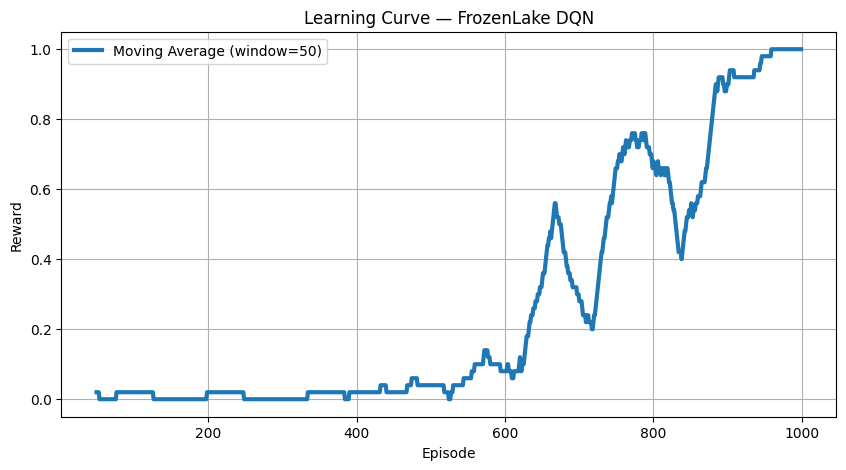

Episode 0
Finished episode 0 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_0.gif
Episode 1
Finished episode 1 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_1.gif
Episode 2
Finished episode 2 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_2.gif
Episode 3
Finished episode 3 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_3.gif
Episode 4
Finished episode 4 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_4.gif
Episode 5
Finished episode 5 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_5.gif
Episode 6
Finished episode 6 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_6.gif
Episode 7
Finished episode 7 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_7.gif
Episode 8
Finished episode 8 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_8.gif
Episode 9
Finished episode 9 with reward 1.0
Saved GIF: results/videos/frozenlake_episode_9.gif


<Figure size 640x480 with 0 Axes>

In [17]:
if __name__ == '__main__':

    frozenlake=FrozenLakeDQN()
    is_slippery=False
    frozenlake.train(1000, is_slippery)
    frozenlake.test(10,is_slippery)

